<a href="https://colab.research.google.com/github/AlexLeoShin/SeminarGit/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
# Игнорировать предупреждения
warnings.filterwarnings('ignore')

# Импорт библиотек

In [3]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro
from scipy.stats import norm

In [4]:
! pip install pingouin
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.2 MB/s eta 0:00:00


**Дисперсионный анализ (ANOVA)** – это мощный статистический метод широко используемый для сравнения средних значений между двумя или более группами. ANOVA позволяет исследователям определить, есть ли статистически значимые различия между группами и является ли какая-то из них доминирующей.


# Однофакторный дисперсионный анализ (ANOVA)

**Однофакторный дисперсионный анализ** позволяет сравнивать **средние значения между двумя и более группами**, которые **различаются только по одной переменной**, **рассматриваемой** в качестве *фактора, влияющего* на результаты исследования.


### **Пример 1.**
Генотерапия, позволяющая корректировать работу дефективного гена, ответственного за развитие заболевания, заключается в увеличении уровня экспрессии дефективного гена. Проведем оценку эффективности четырех различных методов терапии.

Применим **однофакторный дисперсионный анализ**.  

Та **переменная**, которая **будет разделять** наших *испытуемых или наблюдения на группы* (номинативная переменная с нескольким градациями) - **независимая** переменная.

**Количественная переменная**, по степени выраженности которой мы сравниваем группы - **зависимая** переменая.

**Условия применимости дисперсионного анализа**:
## 1. Нормальное распределение
## 2. Гомогенность дисперсии

In [5]:
#загрузим набор данных геннотерапии
gen=pd.read_csv('/content/drive/MyDrive/Статистический_анализ_данных/genetherapy.csv')

In [6]:
# посмотрим что собой представляет датасет
gen.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [7]:
gen.tail()

,expr,Therapy
55,87,D
56,93,D
57,96,D
58,92,D
59,90,D


In [8]:
gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   expr     60 non-null     int64 
 1   Therapy  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [9]:
gen.nunique()

,0
expr,21
Therapy,4


**Н0**: средние значения уровня экспрессии дефективного гена после применения четырёх методов терапии **НЕ отличаются**.

Здесь **Therapy** - независимая категориальная переменная, представляющая 4 вида терапии.

**expr** - зависимая числовая переменная

In [10]:
gen.describe()

,expr
count,60.000000
mean,96.316667
std,5.619252
min,84.000000
25%,93.000000
50%,96.000000
75%,100.000000
max,107.000000


In [11]:
gen.describe(include='object')

,Therapy
count,60
unique,4
top,A
freq,15


In [12]:
# Вычислим среднее, стандартное отклонение и количество переменной экспрессии гена по каждому виду терапии
summary_table = gen.groupby('Therapy')['expr'].agg(['mean', 'std', 'count']).round(2)
print(summary_table)

          mean   std  count
Therapy                    
A        99.73  4.17     15
B        98.80  5.89     15
C        94.40  5.19     15
D        92.33  3.74     15


## Проверка на нормальность

Тест Шапиро-Уилка на нормальность распределения данных

In [13]:
# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по Therapy
for therapy_value, group_data in gen.groupby('Therapy')['expr']:
    result = shapiro(group_data)
    normality_results.append({'Терапия': therapy_value, 'p-value': result.pvalue, 'Нормальное распределение?': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_df = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_df)

  Терапия   p-value  Нормальное распределение?
0       A  0.062011                       True
1       B  0.237401                       True
2       C  0.261578                       True
3       D  0.999785                       True


## Визуализация распределений

* Проверим на нормальность распределение признака экспрессия гена (**expr**) для терапии **А**

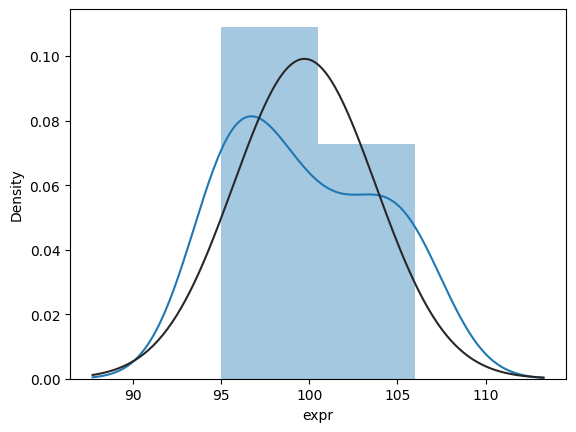

In [14]:
sns.distplot(gen.loc[gen['Therapy'] == 'A', 'expr'].dropna(), fit=norm);

**Выводы:** для терапии-A мы видим, что p-value = 0.062011, это значение больше 0.05, **мы не отвергаем нулевую гипотезу** о нормальности распределения.

Считаем, что уровень переменной экспрессии гена для терапии-A **примерно нормально распределен**.

**Визуализация** **подтверждает вывод**, показывая, что данные терапии-A достаточно **хорошо соответствуют кривой примерно нормального распределения**.

* Проверить на нормальность распределения переменной экспрессия гена для других типов терапий (B,C,D)

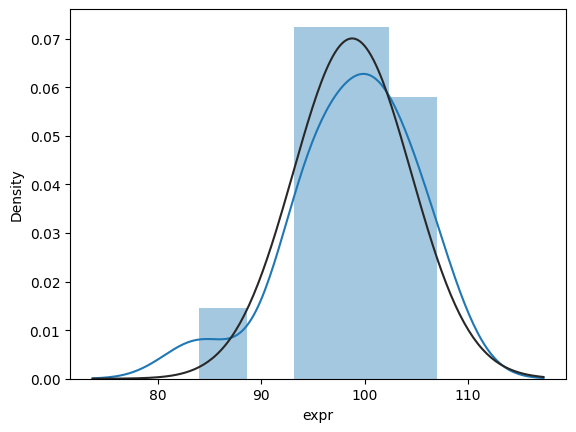

In [15]:
sns.distplot(gen.loc[gen['Therapy'] == 'B', 'expr'].dropna(), fit=norm);

**Выводы:** для терапии-B мы видим, что p-value = 0.237401, это значение больше 0.05, **мы не отвергаем нулевую гипотезу** о нормальности распределения.

Считаем, что уровень переменной экспрессии гена для терапии-B **примерно нормально распределен**.

**Визуализация** **подтверждает вывод**, показывая, что данные терапии-B достаточно **хорошо соответствуют кривой примерно нормального распределения**.

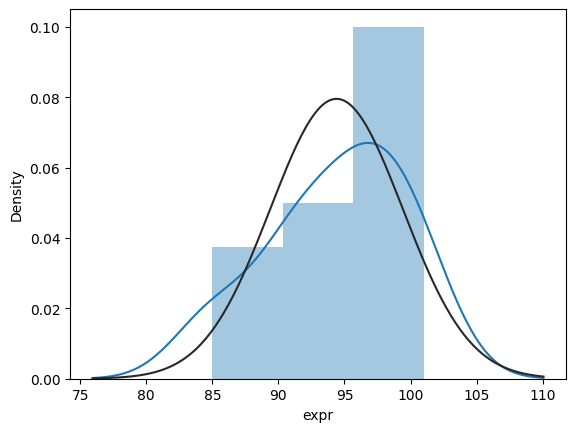

In [16]:
sns.distplot(gen.loc[gen['Therapy'] == 'C', 'expr'].dropna(), fit=norm);

**Выводы:** для терапии-C мы видим, что p-value = 0.261578, это значение больше 0.05, **мы не отвергаем нулевую гипотезу** о нормальности распределения.

Считаем, что уровень переменной экспрессии гена для терапии-C **примерно нормально распределен**.

**Визуализация** **подтверждает вывод**, показывая, что данные терапии-C достаточно **хорошо соответствуют кривой примерно нормального распределения**.

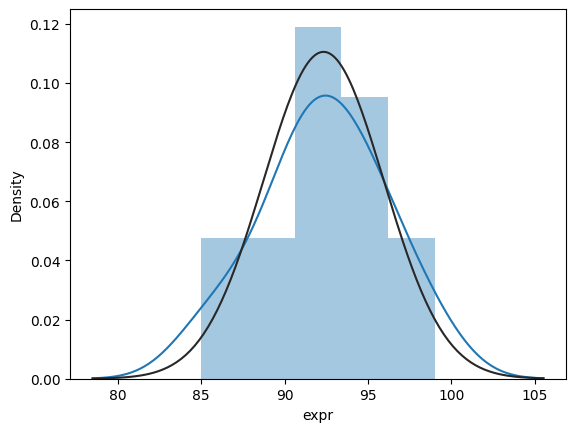

In [17]:
sns.distplot(gen.loc[gen['Therapy'] == 'D', 'expr'].dropna(), fit=norm);

**Выводы:** для терапии-D мы видим, что p-value = 0.999785, это значение больше 0.05, **мы не отвергаем нулевую гипотезу** о нормальности распределения.

Считаем, что уровень переменной экспрессии гена для терапии-D **примерно нормально распределен**.

**Визуализация** **подтверждает вывод**, показывая, что данные терапии-D достаточно (наилучшее соответствие среди всех 4-х терапий) **хорошо соответствуют кривой примерно нормального распределения**.

**Выводы: (дописать)**

На основании результатов теста Шапиро-Уилка для всех четырех групп (A, B, C, D) p-значения значительно превышают уровень значимости 0.05.

**Вывод:** **нулевая гипотеза** о нормальности распределения для каждой группы **не может быть отвергнута**.

***Уровень переменной экспрессии гена*** для всех видов терапии **примерно нормально распределен**, а это однин из ключевых условий для применения однофакторного дисперсионного анализа (ANOVA).

<Figure size 1200x600 with 0 Axes>

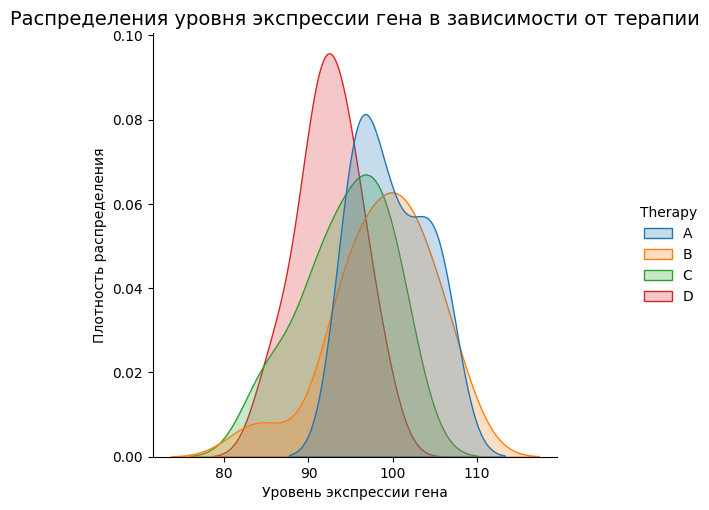

In [18]:
# Создаем отдельные графики распределений переменной expr для разных значений Therapy
plt.figure(figsize=(12, 6))
sns.displot(data=gen, x='expr', hue='Therapy', kind='kde', fill=True, common_norm=False)
plt.title('Распределения уровня экспрессии гена в зависимости от терапии', fontsize=14)
plt.xlabel('Уровень экспрессии гена')
plt.ylabel('Плотность распределения')
plt.show()

## Гомогенность дисперсии

Сначала визуализируем данные с помощью графика боксплот. Посмотрим есть ли выбросы.

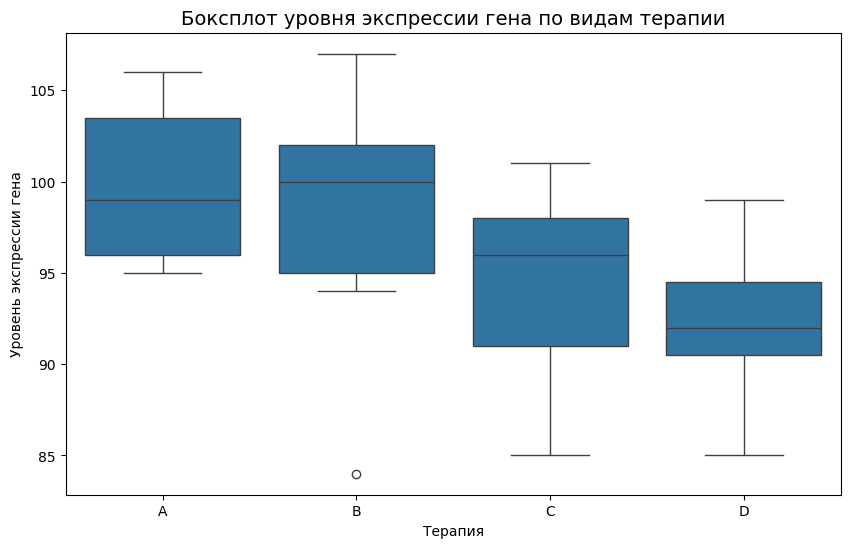

In [19]:
# Создаем боксплоты переменной expr для разных значений Therapy
plt.figure(figsize=(10, 6))
sns.boxplot(data=gen, x='Therapy', y='expr')
plt.title('Боксплот уровня экспрессии гена по видам терапии', fontsize=14)
plt.xlabel('Терапия')
plt.ylabel('Уровень экспрессии гена')
plt.show()

### Тест Левена

**H0**: дисперсии уровня экспрессии гена во всех 4-х группах равны.

**Тест Левена**: функция **levene()** из библиотеки **SciPy**

**Синтаксис:**

levene (sample1, sample2, …, center = '...')

где:

**sample1, sample2** и т. д.: названия групп.

**center**: метод, используемый для теста Левена.

По умолчанию используется «медиана». Другие варианты:

«**median**»: рекомендуется для асимметричных распределений.

«**mean**»: рекомендуется для симметричных распределений со средними хвостами.

«**trimmed**»: рекомендуется для распределений с тяжелыми хвостами.

In [20]:

data_A = gen[gen['Therapy'] == 'A']['expr']
data_B = gen[gen['Therapy'] == 'B']['expr']
data_C = gen[gen['Therapy'] == 'C']['expr']
data_D = gen[gen['Therapy'] == 'D']['expr']

# Проведём тест Левена для проверки гомогенности дисперсий
stats.levene(data_A, data_B, data_C, data_D, center='mean')

LeveneResult(statistic=np.float64(1.071764658870044), pvalue=np.float64(0.3684919438820897))

p-уровень значимости больше, чем 0,05. ***Нулевую гипотезу принимаем***, значит во всех 4-х группах дисперсии равны.
Можно делать дисперсионный анализ.

## Однофакторный дисперсионный анализ


Цель: есть ли статистически значимые отличия между тем, какую терапию принимает наш пациент и влияет это на экспрессию гена.

# **Гипотеза:**

**Но**- Средние значения уровня экспрессии дефективного гена после применения четырёх методов терапии НЕ отличаются.

*Математика: (μA = μB = μC = μD)*

(т.е. простыми словами - *НЕ выажно какой препарат / терпапию мы будем принимать /пользоваться у нас все равно будет одно значение экспрессии гена.*)

**Н1** - Существует статистически значимая разница в средних значениях уровня экспрессии дефективного гена (например: хотя бы между двумя из четырех методов терапии / по крайней мере одно среднее значение отличается от других)



**1 вариант**

In [21]:
# Выделяем группы для каждого значения переменной Therapy
groups = [gen[gen['Therapy'] == group]['expr'] for group in gen['Therapy'].unique()]

# Проводим однофакторный дисперсионный анализ с помощью функции f_oneway пакета scipy.stats
f_statistic, p_value = f_oneway(*groups)

# Выводим результаты
print("F-статистика:", f_statistic)
print("p-значение:", p_value)

F-статистика: 8.037302481143993
p-значение: 0.00015249722895229536


**2 вариант**

In [22]:
# Проводим однофакторный дисперсионный анализ с помощью библиотеки statsmodels
model = ols('expr ~ Therapy', data=gen).fit()
anova_results = anova_lm(model)

# Выводим результаты
print(anova_results)

            df       sum_sq     mean_sq         F    PR(>F)
Therapy    3.0   560.716667  186.905556  8.037302  0.000152
Residual  56.0  1302.266667   23.254762       NaN       NaN


**Выводы:** p-значение = 0.000152 значительно меньше стандартного уровня значимости (α = 0.05).

**Существуют** статистически значимые различия в среднем уровне экспрессии дефективного гена между различными методами терапии.

**Метод применяемой терапии оказывает значимое влияние** на уровень экспрессии гена.

**Нулевая гипотеза отвергается.**

*Вывод (коротко):* дисперсии уровня экспрессии гена во всех 4-х группах НЕ равны.

Визуализируем данные с помощью доверительных интервалов с указанием среднего значения

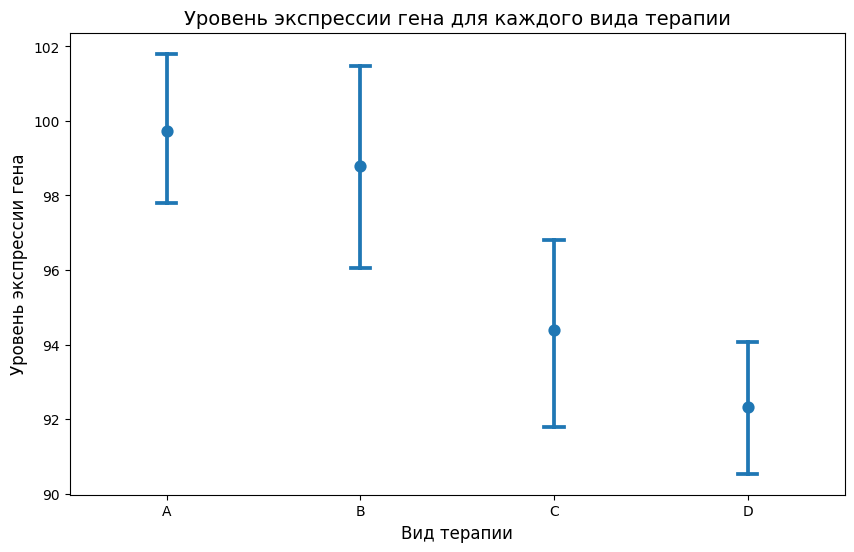

In [24]:
plt.figure(figsize=(10, 6))
#доверительныq интервал с указанием среднего значения ci=95
sns.pointplot(x='Therapy', y='expr', data=gen, ci=95, capsize=.1, join=False)
plt.xlabel('Вид терапии', fontsize=12)
plt.ylabel('Уровень экспрессии гена', fontsize=12)
plt.title('Уровень экспрессии гена для каждого вида терапии', fontsize=14)
plt.show()

# ***Если доверительные интервалы не включают средние значения друг друга, то такие различия будут значимыми.***

*Если включают средние значения друг друга, то статистически значимых различий не обнаружено (или они не являются достаточно сильными, чтобы быть выявленными таким способом).*

1. Между какими именно парами средних существуют значимые различия (что показал нам дисперсионный анализ)?

2. Какие виды терапии лучше справляются со своей задачей?

**Выводы на результатах однофакторного дисперсионного анализа (ANOVA):** (*Между какими именно парами средних существуют значимые различия (что показал нам дисперсионный анализ)?*)

**Существуют значимые различия:**

- Терапия A имеет заметные отличия от Терапии C и Терапии D, доверительные интервалы **НЕ перекрываются**.

- Терапия B также значительно отличается от Терапии D, их интервалы **НЕ перекрываются**.

**НЕ существует значимых различий:**
    
- Между Терапией A и B доверительные интервалы **перекрываются**, что указывает на отсутствие статистически значимых различий между ними.
    
- Между Терапией B и C доверительные интервалы **перекрываются.**
    
- Между Терапией C и D доверительные интервалы **перекрываются.**

**Вывод по вопросу 1:** Значимые различия существуют между следующими парами терапий:

    A и C
    A и D
    B и D






*Также отметим:* терапия A и B в среднем показывают более высокий уровень экспрессии гена по сравнению с терапиями C и D, а также терапия A и B выше чем D.


**Выводы** (*Какие виды терапии лучше справляются со своей задачей?*):

- Терапии A и B в среднем показывают наиболее высокий уровень экспрессии гена.
    
- Статистически значимой разницы между терапиями A и B не обнаружено.

- Терапии A и B статистически значимо отличаются от терапий C и D, при этом их средние значения выше, что соответствует цели увеличения экспрессии гена.

- Между терапиями C и D статистически значимых различий также не обнаружено.

**Резюме:** **терапии A и B лучше всего справляются со своей задачей**, демонстрируя наибольшее увеличение уровня экспрессии дефективного гена.

***Между терапиями A и B визуально не обнаружено явных различий, что позволяет считать их обе эффективными.***


# Множественные сравнения в ANOVA


## **Критерий Тьюки**

**Критерий Тьюки** - статистический метод, который используется после того, как было обнаружено статистически значимое различие среди групп в однофакторном дисперсионном анализе. Он позволяет определить, какие конкретные группы различаются между собой.

Функция `pairwise_tukeyhsd` из пакета `statsmodels.stats`

In [25]:
tukey = pairwise_tukeyhsd(endog = gen['expr'], groups = gen['Therapy'], alpha = 0.05)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.9333,0.9514,-5.5959,3.7292,False
A,C,-5.3333,0.0189,-9.9959,-0.6708,True
A,D,-7.4,0.0005,-12.0626,-2.7374,True
B,C,-4.4,0.071,-9.0626,0.2626,False
B,D,-6.4667,0.0029,-11.1292,-1.8041,True
C,D,-2.0667,0.6458,-6.7292,2.5959,False


* Сделаем результат в виде таблицы

In [26]:
df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
df_tukey

,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-0.9333,0.9514,-5.5959,3.7292,False
1,A,C,-5.3333,0.0189,-9.9959,-0.6708,True
2,A,D,-7.4000,0.0005,-12.0626,-2.7374,True
3,B,C,-4.4000,0.0710,-9.0626,0.2626,False
4,B,D,-6.4667,0.0029,-11.1292,-1.8041,True
5,C,D,-2.0667,0.6458,-6.7292,2.5959,False


Если интервал разности средних не включает 0, то можно отклонить нулевую гипотезу о равенстве
средних.

**Выводы:** Группы A и C, A и D, B и D - значимо отличаются между собой

* Визуализируем результаты теста Тьюки

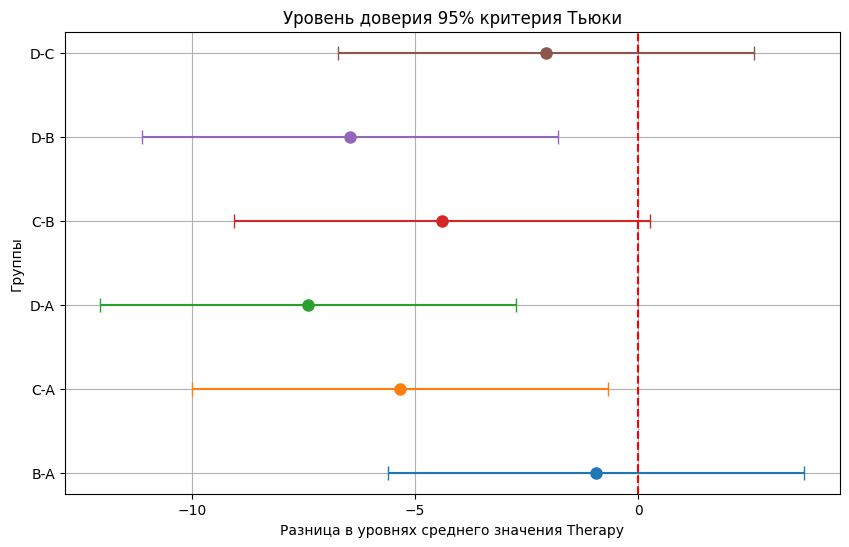

In [27]:
# Тест Тьюки
tukey = pairwise_tukeyhsd(endog=gen['expr'], groups=gen['Therapy'], alpha=0.05)

# Конвертируем результаты теста Тьюки в таблицу данных
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# Данные для построения графика из таблицы
group_pairs = [(row[0], row[1]) for row in tukey_df[['group1', 'group2']].values]
mean_diffs = list(tukey_df['meandiff'])
lower_bounds = list(tukey_df['lower'])
upper_bounds = list(tukey_df['upper'])

# Создаем график
plt.figure(figsize=(10, 6))
for i in range(len(group_pairs)):
    plt.errorbar(mean_diffs[i], i, xerr=[[mean_diffs[i] - lower_bounds[i]], [upper_bounds[i] - mean_diffs[i]]], fmt='o', capsize=5, markersize=8)

plt.axvline(x=0, color='red', linestyle='--')

# Настройки осей
plt.yticks(range(len(group_pairs)), [f'{pair[1]}-{pair[0]}' for pair in group_pairs])
plt.ylabel('Группы')
plt.xlabel('Разница в уровнях среднего значения Therapy')
plt.xticks([-10, -5, 0])

# Добавляем заголовок
plt.title('Уровень доверия 95% критерия Тьюки')

# Показываем график
plt.grid(True)
plt.show()

**Вывод по визуализации Теста Тьюки:**

Группы:  
- A и C
- A и D
- B и D

***Значимо отличаются между собой поскольку их доверительный 95% интервал по критерию Тьюки  не пересекает значение 0***


# Двухфакторный дисперсионный анализ

**Двухфакторный дисперсионный анализ** применяется для проверки возможной зависимости результативного признака **от двух факторов.**


### **Пример 2.**
Необходимо исследовать уровень экспрессии в зависимости от возраста пациента и дозировки лекарства аторвастатина.

In [28]:
ater=pd.read_csv('/content/drive/MyDrive/Статистический_анализ_данных/atherosclerosis.csv')

In [29]:
ater

,expr,age,dose
0,107.351478,1,D1
1,104.504438,1,D1
2,103.435134,1,D1
3,109.572882,1,D1
4,114.993803,1,D1
...,...,...,...
59,101.851582,2,D2
60,105.239530,2,D2
61,99.350198,2,D2
62,108.091455,2,D2


In [30]:
ater.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   expr    64 non-null     float64
 1   age     64 non-null     int64  
 2   dose    64 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


## Проверка на нормальность

# **Гипотеза (при проверке на нормальность, гомогенность/однородность и при проведении дисперсионного анализа):**

***1. Гипотезы для основного эффекта фактора 'возраст' (age):***

- Нулевая гипотеза (H0_age): **Нет статистически значимой разницы** в среднем уровне экспрессии гена между различными возрастными группами (т.е. возраст не влияет на уровень экспрессии гена).
    
- Альтернативная гипотеза (H1_age): Существует статистически значимая разница в среднем уровне экспрессии гена между различными возрастными группами (т.е. возраст влияет на уровень экспрессии гена).

**2. Гипотезы для основного эффекта фактора 'дозировка' (dose):**

- Нулевая гипотеза (H0_dose): **Нет** статистически значимой разницы в среднем уровне экспрессии гена между различными дозировками лекарства (т.е. дозировка не влияет на уровень экспрессии гена).
    
- Альтернативная гипотеза (H1_dose): Существует статистически значимая разница в среднем уровне экспрессии гена между различными дозировками лекарства (т.е. дозировка влияет на уровень экспрессии гена).

**3. Гипотезы для эффекта взаимодействия 'возраст * дозировка' (age:dose)**

- Нулевая гипотеза (H0_interaction): **Отсутствует (НЕТ)** статистически значимое взаимодействие между возрастом и дозировкой лекарства в их влиянии на уровень экспрессии гена (т.е. влияние возраста на экспрессию гена не зависит от дозировки, и наоборот).
    
- Альтернативная гипотеза (H1_interaction): Существует статистически значимое взаимодействие между возрастом и дозировкой лекарства в их влиянии на уровень экспрессии гена (т.е. влияние возраста на экспрессию гена зависит от дозировки, и наоборот).

In [31]:
# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по дозе гормона (дозы: D1 и D2)
for therapy_value, group_data in ater.groupby('dose')['expr']:
    result = shapiro(group_data)
    normality_results.append({'dose': therapy_value, 'p-value': result.pvalue, 'Нормальность': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_ater = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_ater)

  dose   p-value  Нормальность
0   D1  0.657510          True
1   D2  0.312119          True


In [32]:
# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по возрасту
for therapy_value, group_data in ater.groupby('age')['expr']:
    result = shapiro(group_data)
    normality_results.append({'age': therapy_value, 'p-value': result.pvalue, 'Нормальность': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_ater1 = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_ater1)

   age   p-value  Нормальность
0    1  0.204927          True
1    2  0.713375          True


## Гомогенность дисперсии

In [33]:
data_1 = ater[ater['dose'] == 'D1']['expr']
data_2 = ater[ater['dose'] == 'D2']['expr']

# Проводим тест Левена для проверки гомогенности дисперсий
stats.levene(data_1, data_2, center='mean')

LeveneResult(statistic=np.float64(0.03931943734898134), pvalue=np.float64(0.8434659230532853))

In [34]:
import scipy.stats as stats

dat_1 = ater[ater['age'] == 1]['expr']
dat_2 = ater[ater['age'] == 2]['expr']

# Проводим тест Левена для проверки гомогенности дисперсий
stats.levene(dat_1, dat_2, center='mean')

LeveneResult(statistic=np.float64(0.08436868351041557), pvalue=np.float64(0.772431504114608))

### Дисперсионный анализ

In [35]:
#Дисперсионный анализ
model = ols('expr ~ dose + age + dose:age', data=ater).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
dose,16.912241,1.0,0.638094,0.427552
age,197.452754,1.0,7.449841,0.008313
dose:age,0.927077,1.0,0.034978,0.852272
Residual,1590.257424,60.0,NaN,NaN


**Выводы:**
Двухфакторный дисперсионный анализ показывает, что **существует статистически значимая разница** в среднем уровне экспрессии гена **между различными возрастными группами**(т.е. **ТОЛЬКО возраст** влияет на уровень экспрессии гена).

**ПОДСКАЗКА в выборе метода применения:**

*Если в условиях написано:*

**"Зависит"** - использовать какой-то Тест (t-тест, Стьюдента, Манна-Уитни и т.д.)

**"Влияет"** - это дисперсионный анализ

### Визуализация

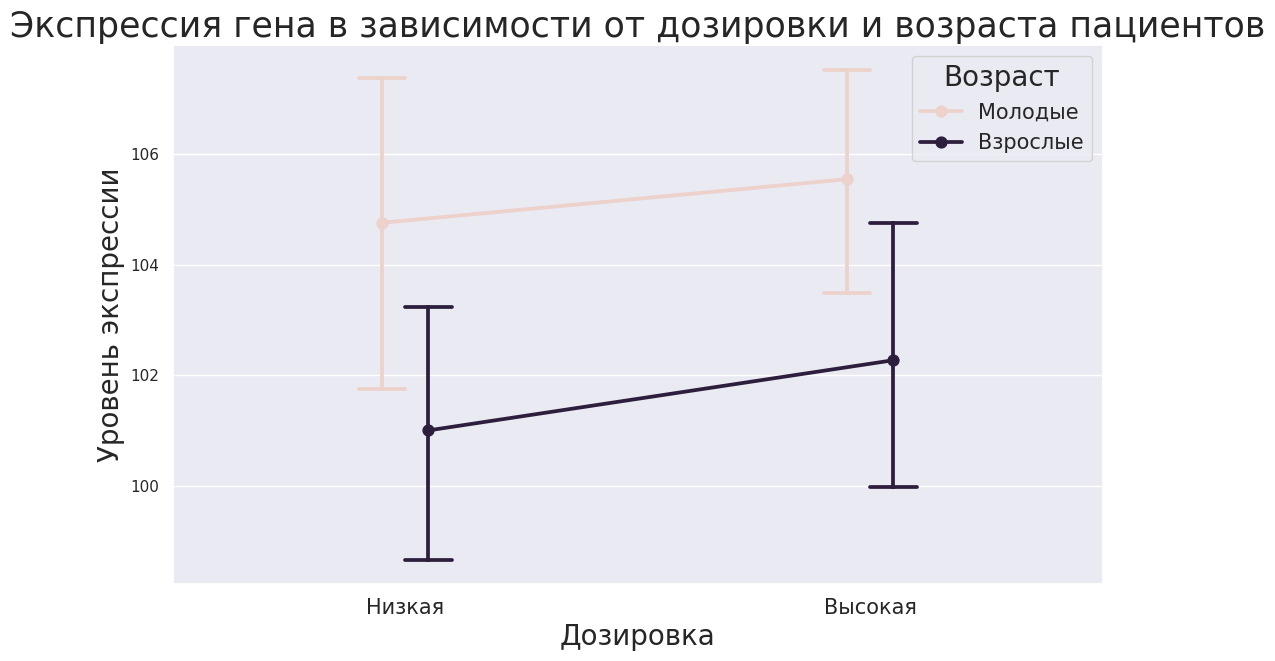

In [40]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(12, 7)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='dose', y='expr', hue='age', dodge=0.1, capsize=.1, data=ater)

# меняем названия титула, оси х и оси у
plt.title('Экспрессия гена в зависимости от дозировки и возраста пациентов', fontsize=25)
plt.xlabel('Дозировка', fontsize=20)
plt.ylabel('Уровень экспрессии', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Низкая', 'Высокая')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Молодые', 'Взрослые'], title='Возраст', title_fontsize=20, fontsize=15);

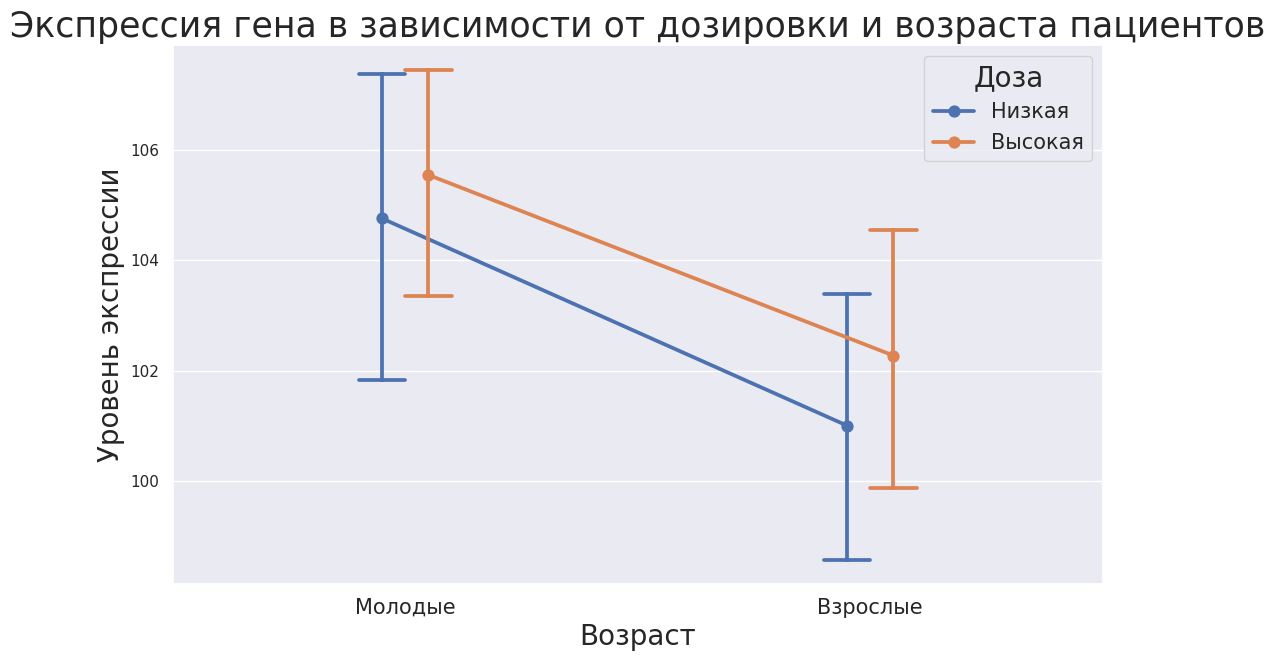

In [41]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(12, 7)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='age', y='expr', hue='dose', dodge=0.1, capsize=.1, data=ater)

# меняем названия титула, оси х и оси у
plt.title('Экспрессия гена в зависимости от дозировки и возраста пациентов', fontsize=25)
plt.xlabel('Возраст', fontsize=20)
plt.ylabel('Уровень экспрессии', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Молодые', 'Взрослые')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Низкая', 'Высокая'], title='Доза', title_fontsize=20, fontsize=15);

**Выводы:**
Визуализация двухфакторного дисперсионного анализа показывает, что **существует статистически значимая разница** в среднем уровне экспрессии гена **между различными возрастными группами**(т.е. **ТОЛЬКО возраст** влияет на уровень экспрессии гена).

**Выводы на основе визуализаций в контексте двухфакторного дисперсионного анализа:**



- **Влияние возраста (age):** Обе визуализации (особенно второй график, где по оси X отложен возраст) наглядно показывают, что **возраст оказывает статистически значимое влияние на уровень экспрессии гена.**

**Средний уровень экспрессии гена у 'Молодых' пациентов значительно выше, чем у 'Взрослых'. **

**- Влияние дозировки (dose):** На обоих графиках линии, представляющие разные дозировки (D1 и D2), расположены относительно близко друг к другу.

Дозировка не оказывает статистически значимого влияния на уровень экспрессии гена.

**- Взаимодействие возраста и дозировки (age:dose):** На обоих графиках линии для разных групп (возраста на первом графике, дозировки на втором) выглядят относительно параллельными.

**Отсутствует статистически значимое взаимодействие между возрастом и дозировкой в их влиянии на экспрессию гена.** То есть, влияние возраста на экспрессию гена не меняется существенно в зависимости от дозировки, и наоборот.

**Общий вывод:** Визуализации подтверждают результаты двухфакторного дисперсионного анализа: **только возраст пациентов является статистически значимым фактором**, влияющим на уровень экспрессии гена.

Дозировка лекарства и взаимодействие возраста с дозировкой не оказывают значимого влияния.

### **Пример 3.** Влияние гормона на показатель концентрации кальция в крови с учетом пола.

**Гипотезы:**

**1. Гипотезы для основного эффекта фактора 'гормон' (hormone):**

 - Нулевая гипотеза (H0_hormone): Нет статистически значимой разницы в среднем показателе концентрации кальция в крови при наличии или отсутствии гормона (т.е. гормон не влияет на концентрацию кальция).
    
- Альтернативная гипотеза (H1_hormone): Существует статистически значимая разница в среднем показателе концентрации кальция в крови при наличии или отсутствии гормона (т.е. гормон влияет на концентрацию кальция).

**2. Гипотезы для основного эффекта фактора 'пол' (sex):**

- Нулевая гипотеза (H0_sex): Нет статистически значимой разницы в среднем показателе концентрации кальция в крови между различными полами (т.е. пол не влияет на концентрацию кальция).
    
- Альтернативная гипотеза (H1_sex): Существует статистически значимая разница в среднем показателе концентрации кальция в крови между различными полами (т.е. пол влияет на концентрацию кальция).

**3. Гипотезы для эффекта взаимодействия 'гормон * пол' (hormone:sex):**

- Нулевая гипотеза (H0_interaction): Отсутствует статистически значимое взаимодействие между гормоном и полом в их влиянии на показатель концентрации кальция в крови (т.е. влияние гормона на концентрацию кальция не зависит от пола, и наоборот).
    
- Альтернативная гипотеза (H1_interaction): Существует статистически значимое взаимодействие между гормоном и полом в их влиянии на показатель концентрации кальция в крови (т.е. влияние гормона на концентрацию кальция зависит от пола, и наоборот).


In [42]:
gor = pd.read_csv('/content/drive/MyDrive/Статистический_анализ_данных/gormon.csv')

In [43]:
gor

,var4,hormone,sex
0,17.859039,1,1
1,20.842343,1,1
2,19.318099,1,1
3,20.064451,1,1
4,17.620316,1,1
...,...,...,...
59,17.054195,0,0
60,22.951551,0,0
61,18.799382,0,0
62,16.543161,0,0


In [44]:
gor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   var4     64 non-null     float64
 1   hormone  64 non-null     int64  
 2   sex      64 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.6 KB


In [45]:
#Дисперсионный анализ
model = ols('var4 ~ hormone + sex + hormone:sex', data=gor).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
hormone,0.847472,1.0,0.086528,0.769653
sex,0.119762,1.0,0.012228,0.912318
hormone:sex,89.483384,1.0,9.136390,0.003682
Residual,587.650394,60.0,NaN,NaN


**Выводы:** ни один из факторов не оказывает значимого влияния на концентрацию кальция в крови, **ТОЛЬКО** их взаимодействие оказывает.

Построим график результатов

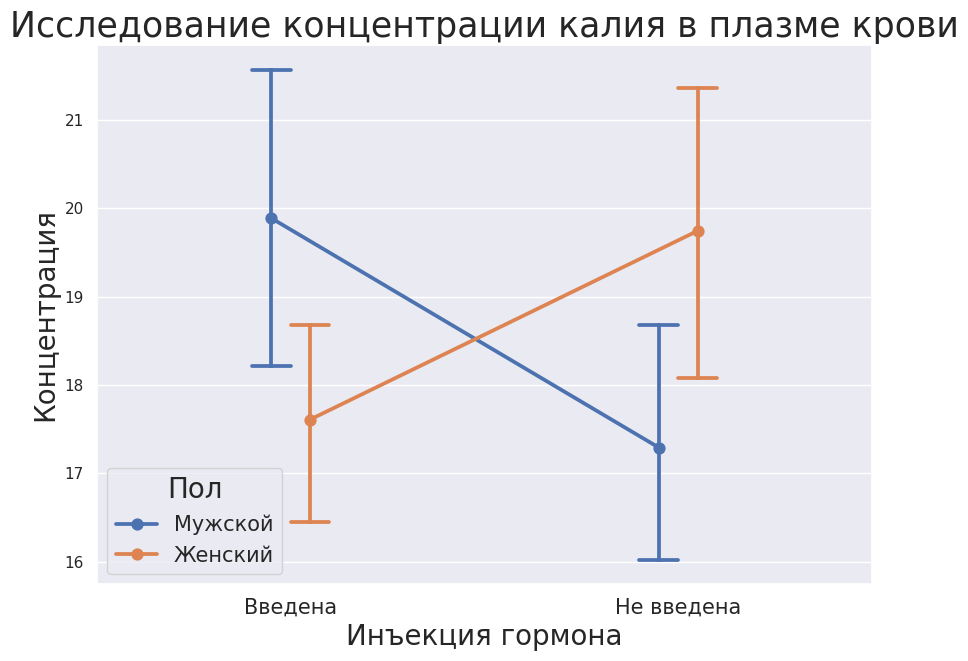

In [47]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(10, 7)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='hormone', y='var4', hue='sex', dodge=0.1, capsize=.1, data=gor)

# меняем названия титула, оси х и оси у
plt.title('Исследование концентрации калия в плазме крови', fontsize=25)
plt.xlabel('Инъекция гормона', fontsize=20)
plt.ylabel('Концентрация', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Введена', 'Не введена')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Мужской', 'Женский'], title='Пол', title_fontsize=20, fontsize=15);


**Вывод по визуализации:** Факт инъекции по-разному повлиял на концентрацию калия в крови. В случае женского пола это привело к увеличению показателя, а мужского - к снижению кальция в крови.

**Выводы:**
* Применение дисперсионного анализа не даёт оснований говорить о причинно-следственной зависимости данных.
* Ошибки корреляции возможны и при применении дисперсионного анализа.
* Дисперсионный анализ проверяет гипотезу о взаимосвязи номинативной переменной (например, вид терапии, профессия испытуемого) и некоторой количественной переменной (например, уровень экспрессии гена, балл по статистике).

# ПРАКТИКА



Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

1. В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные   
2. Во втором: была обновлена кнопка заказа, и часть пользователей видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Задания  
**Первая задача**
1. Проведите тест на нормальность распределения.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.  
3. Выберите метод, который поможет решить первую задачу.  
4. Сравните средние в представленных группах.  
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.   
6. Примите решение: какие картинки в итоге будем использовать?

**Вторая задача** **(необязательное, для умнышек)**
1. Выберите метод для второго теста.  
2. Визуализируйте распределение events для контрольной и тестовой групп.   
3. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.   
4. Выберите формулу для модели, проведите тест.  
5. Визуализируйте результаты теста и заполните пропуски.    

## Описание данных

`Набор1`:  

· id – id клиента в эксперименте  
· group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
· events – сколько блюд суммарно было заказано за период  

`Набор2`:

· id – id клиента в эксперименте  
· segment – сегмент (high/low)  
· group – вид кнопки (control – старая версия, test – новая версия)  
· events – сколько блюд суммарно было заказано за период

### **Первая задача:**
Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

* A – прямоугольные 16:9
* B – квадратные
* C – прямоугольные 12:4

Будем использовать дисперсионный анализ, так как у нас 3 группы, если будут выполнены условия о нормальности и однородности

In [48]:
df1 = pd.read_csv('/content/drive/MyDrive/Статистический_анализ_данных/Набор1.csv')

In [49]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [50]:
A = df1.query('group == "A"').events
B = df1.query('group == "B"').events # ДОПИШИТЕ КОД
C = df1.query('group == "C"').events # ДОПИШИТЕ КОД

**Гипотезы:**

- Нулевая гипотеза (H0): **Нет** **статистически значимой разницы в среднем количестве заказанных блюд** между группами, которым показывались фотографии с различными форматами (A, B, C).

(среднее количество заказов одинаково для всех трех форматов)

- Альтернативная гипотеза (H1): **Существует статистически значимая разница в среднем количестве заказанных блюд** хотя бы между двумя из трех групп.

(среднее количество заказов не одинаково для всех форматов)

## Метод .sample()

Есть шанс, что случайные 1000 значений сформируют ненормальное распределение, поэтому рекомендуем использовать аргумент random_state=17 для стабильности и воспроизводимости результатов.

* **1. Проверим данные на нормальность, применив тест Шапиро-Уилка.**

Перед применением критерия при проверке на нормальность сделаем семплирование (1000 наблюдений). Для воспроизводимости результата используйте параметр random_state=17 в методе sample.


In [51]:
stats.shapiro(A.sample(1000, random_state=17))

ShapiroResult(statistic=np.float64(0.9973138685756308), pvalue=np.float64(0.0958664550339529))

In [52]:
stats.shapiro(B.sample(1000, random_state=17)) # НАПИШИТЕ КОД

ShapiroResult(statistic=np.float64(0.9980819475724109), pvalue=np.float64(0.3186658905454146))

In [53]:
stats.shapiro(C.sample(1000, random_state=17)) # НАПИШИТЕ КОД

ShapiroResult(statistic=np.float64(0.9981201274607922), pvalue=np.float64(0.3366435414670874))

**Дополнительно (необязательно):** попробуйте посчитать тест Шапиро-Уилка без использования метода sample.

* **2. Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.**

In [54]:
stats.levene(A,B,C) # ДОПИШИТЕ КОД

LeveneResult(statistic=np.float64(2.2622596339318037), pvalue=np.float64(0.1041327199523974))

* **3. Выберите метод, который поможет решить первую задачу.**

**Выбор метода:** Мы выберем Однофакторный дисперсионный анализ (ANOVA).

**Обоснование:**

**- Количество групп:** У нас - три независимые группы (A, B, C), между которыми мы хотим сравнить средние значения (количество заказанных блюд).
    
**- Нормальность распределения:** Провели тест Шапиро-Уилка для каждой группы.

**результаты:** для всех групп p-значения были значительно выше 0.05 (0.095, 0.318, 0.336 соответственно), что **позволяет нам не отвергать нулевую гипотезу о нормальности распределения.**

Значит, **данные в каждой группе примерно нормально распределены.**
    
    
**- Гомогенность дисперсий:** проверили гомогенность дисперсий с помощью теста Левена в см. п.2.

**результаты:** p-значение (0.104) также выше 0.05, что **позволяет нам не отвергать нулевую гипотезу о равенстве дисперсий.**

Значит, **данные в каждой группе примерно нормально распределены.**

**Выполнены оба основных условия для применения параметрического однофакторного ANOVA** - (нормальность и гомогенность дисперсий), метод наиболее подходящий для сравнения средних значений в наших трех группах.

Сравним группы, используя __ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ__.

**1 способ**

In [60]:
stats.f_oneway(A,B,C) # ДОПИШИТЕ КОД

F_onewayResult(statistic=np.float64(2886.1666574389624), pvalue=np.float64(0.0))

**Вывод:** pvalue=np.float64(0.0))

**Отвергаем нулевую гипотезу о том, что НЕТ статистически значимой разницы в среднем количестве заказанных блюд** между группами, которым показывались фотографии с различными форматами (A, B, C)

**2 способ**

In [61]:
# Проводим однофакторный дисперсионный анализ с помощью библиотеки statsmodels
model = ols('events ~ group', data=df1).fit() # ДОПИШИТЕ КОД
anova_results = anova_lm(model)

# Выводим результаты
print(anova_results)

               df        sum_sq        mean_sq            F  PR(>F)
group         2.0  5.729361e+05  286468.062300  2886.166657     0.0
Residual  29997.0  2.977369e+06      99.255551          NaN     NaN


**результат:** p-значение для group равно 0.0, что намного меньше 0.05.

Значит **нулевая гипотеза отвергается**,

и

**значит существует статистически значимая разница в среднем количестве заказанных блюд между группами с разными форматами фотографий**.

 * **4. Сравните средние в представленных группах.**

In [62]:
mean_events_group = df1.groupby('group')['events'].mean()
print("Среднее количество заказанных блюд по группам:")
print(mean_events_group)

Среднее количество заказанных блюд по группам:
group
A    29.5796
B    37.6136
C    27.4703
Name: events, dtype: float64


**Анализ сравнения в среднем количестве:**


- Группа B (квадратные изображения) имеет самое высокое среднее количество заказов (37.61).
    
- Группа A (прямоугольные 16:9) занимает второе место (29.58).

- Группа C (прямоугольные 12:4) имеет наименьшее среднее количество заказов (27.47).


**Вывод:**
**Общие различия статистически значимы** (по ANOVA) и расчитали средние значения количества заказанных блюд по группам.

**Можем переходить к определению между какими именно парами групп эти различия статистически значимы (критерий Тьюки)**

* **5. Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.**

In [63]:
tukey = pairwise_tukeyhsd(endog = df1['events'], groups = df1['group'], alpha = 0.05)
print(tukey.summary())
df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(df_tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034   0.0   7.7038  8.3642   True
     A      C  -2.1093   0.0  -2.4395 -1.7791   True
     B      C -10.1433   0.0 -10.4735 -9.8131   True
----------------------------------------------------
  group1 group2  meandiff  p-adj    lower   upper  reject
0      A      B    8.0340    0.0   7.7038  8.3642    True
1      A      C   -2.1093    0.0  -2.4395 -1.7791    True
2      B      C  -10.1433    0.0 -10.4735 -9.8131    True


Можно проще:

In [64]:
print(pairwise_tukeyhsd(df1['events'], df1['group']).summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034   0.0   7.7038  8.3642   True
     A      C  -2.1093   0.0  -2.4395 -1.7791   True
     B      C -10.1433   0.0 -10.4735 -9.8131   True
----------------------------------------------------


**Выводы:** статистически значимые отличия есть между всеми группами (т.е. каждый формат фотографий (A, B, C) оказывает статистически значимое разное влияние на количество заказанных блюд.)

Значение p-adj (p-значение) равно 0.0, что значительно меньше уровня значимости alpha = 0.05. Соответственно, столбец reject содержит True для всех этих пар.

* Визуализируем

Text(0, 0.5, 'Число покупок')

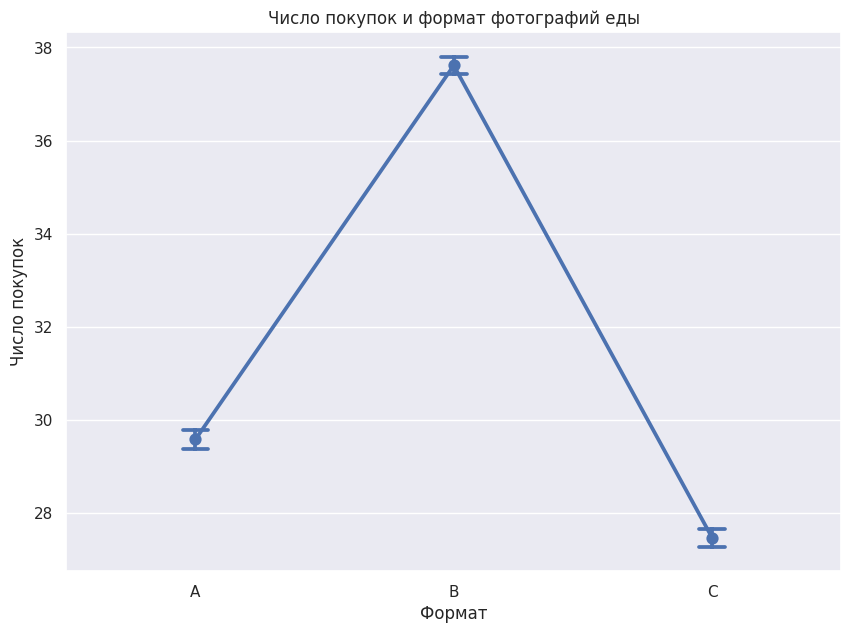

In [65]:
sns.pointplot(x='group', y='events', data=df1, capsize=.1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

* Так какие картинки в итоге будем использовать?

**Ответ:**

**Квадратные картинки** будем использовать. Поскольку среднее наибольшее и статистически значимо отличается от А и С)


### **Вторая задача**
Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Скорее всего нам пригодится многофакторный дисперсионный анализ (поскольку два фактора)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/ПК-ППК/Дисперсионный анализ/Набор2.csv')

In [ ]:
df2.head()

Посмотрим на данные. Визуализируйте распределение events для контрольной и тестовой групп.

In [ ]:
sns.distplot(df2.query('group=="control"').events, kde=False);

In [ ]:
sns.distplot(df2.query('group=="test"').events, kde=False);

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

Выберите формулу для модели. Напоминание:мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.



__· events ~ segment + group + segment:group__  


In [ ]:
model = ols(formula='', data=df2).fit() # ДОПИШИТЕ КОД
aov_table = anova_lm(model, typ=2)

In [ ]:
print(round(aov_table, 2))

Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения (**выделите их жирным**):

· Для обоих сегментов показатели статистически значимо _уменьшились_ по сравнению с контрольной группой  
· Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой  
· Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 36  
· Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13    
· Разница между control/high и test/high составила около 10  
· Различий совсем не оказалось

In [ ]:
df2['combination'] = df2.group + ' \ ' + df2.segment

In [ ]:
df2.head()

In [ ]:
print(pairwise_tukeyhsd(df2['events'], df2['combination']).summary())

Визуализируйте результаты теста

In [ ]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = df2, capsize = .1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

In [ ]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = df2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

**Выводы: (заполните пропуски)** Фактор group оказался ...(подсказка: значимым/незначимым), фактор segment – ..., их взаимодействие – .... Судя по графику, для всех групп среднее значение events ..., поэтому решение: ....

# ЗАДАНИЕ ДЛЯ ИТОГОВОГО ПРОЕКТА ПО МОДУЛЮ СТАТАНАЛИЗ

* Загрузите датасет **heart1.csv** из работы по визуализации (без кодировки категорийных данных)
* Постройте 3 гипотезы о влиянии любых 3-х, выбранных Вами признаков из датасета на целевую переменную (ССЗ) и проверьте с помощью подходящих тестов ваши гипотезы.

Для этого не забудьте проверить распределение ваших признаков на нормальность, однородность дисперсий. Обоснуйте выбор тестов. Сделайте выводы.

Задание выполняем в блокноте **Итоговый проект_Фамилияю.ipynb**. Для этого создаём текстовую ячейку "Статистический анализ данных" после EDA.